In [23]:
import sys
import torch
import os
import numpy as np
from matplotlib import pyplot as plt
import cv2

path_before = sys.path
sys.path.append("/workspaces/src/rPPG-Toolbox")

import neural_methods.model.PhysNet as PhysNet
import neural_methods.model.PhysNetUncertainty as PhysNetUncertainty
import neural_methods.model.PhysNetQuantile as PhysNetQuantile
import neural_methods.model.model_wrappers as model_wrappers

sys.path = path_before


dataset_path = "/mnt/results/preprocessed_rppgToolbox/VitalVideos_SizeW72_SizeH72_ClipLength160_DataTypeDiffNormalized_Standardized_DataAugNone_LabelTypeDiffNormalized_Crop_faceTrue_BackendY5F_Large_boxTrue_Large_size1.5_Dyamic_DetTrue_det_len30_Median_face_boxFalse_DNone_amp10.0"
#model_path = "/workspaces/src/rPPG-Toolbox/runs/exp/VitalVideos_and_UBFC_SizeW72_SizeH72_ClipLength160_DataTypeDiffNormalized_Standardized_DataAugNone_LabelTypeDiffNormalized_Crop_faceTrue_BackendY5F_Large_boxTrue_Large_size1.5_Dyamic_DetTrue_det_len30_Median_face_boxFalse_DNone_amp10.0/PreTrainedModels/VitalLens_Physnet_best.pth"
model_path = "/workspaces/src/rPPG-Toolbox/runs/exp/VitalVideos_and_UBFC_SizeW72_SizeH72_ClipLength160_DataTypeDiffNormalized_Standardized_DataAugNone_LabelTypeDiffNormalized_Crop_faceTrue_BackendY5F_Large_boxTrue_Large_size1.5_Dyamic_DetTrue_det_len30_Median_face_boxFalse_DNone_amp10.0/PreTrainedModels/VitalLens_Physnet_Lifeness_NegLogLikelihood_best.pth"

model_name = "uncertainty" 

np.random.seed(42)  # Replace 42 with any integer

In [24]:

if model_name == "uncertainty":
    model = PhysNetUncertainty.PhysNet_Uncertainty(frames=160)
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
    is_uncertainty_model = True
elif model_name == "quantile":
    model = PhysNetQuantile.PhysNet_Quantile(frames=160)
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
    is_uncertainty_model = True
else:
    model = PhysNet.PhysNet_padding_Encoder_Decoder_MAX(frames=160)
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
    model = model_wrappers.PhysNet_Wrapper(model_path, frames=160)
    is_uncertainty_model = False

model.eval()

PhysNet_Uncertainty(
  (ConvBlock1): Sequential(
    (0): Conv3d(3, 16, kernel_size=(1, 5, 5), stride=(1, 1, 1), padding=(0, 2, 2))
    (1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (ConvBlock2): Sequential(
    (0): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (ConvBlock3): Sequential(
    (0): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (ConvBlock4): Sequential(
    (0): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (ConvBlock5): Sequential(
    (0): Conv3d(64, 

In [25]:
in_files = os.listdir(dataset_path)
in_files = [f for f in in_files if "input" in f and f.endswith(".compressed.npz")]
in_files = sorted(in_files)
print(f"Found {len(in_files)} input files in the dataset directory.")

file_to_use = '81_input0.npy.compressed.npz'
input_path = os.path.join(dataset_path, file_to_use)
print(f"Using input file: {input_path}")

input_tensor = np.load(input_path)['array1']
input_tensor = np.expand_dims(input_tensor, axis=0)
input_tensor = np.transpose(input_tensor, (0, 4, 1, 2, 3))
standardized_input = input_tensor[:, 3:, :, :, :]
diff_normalized_input = input_tensor[:, :3, :, :, :]

print(diff_normalized_input.shape)

Found 1010 input files in the dataset directory.
Using input file: /mnt/results/preprocessed_rppgToolbox/VitalVideos_SizeW72_SizeH72_ClipLength160_DataTypeDiffNormalized_Standardized_DataAugNone_LabelTypeDiffNormalized_Crop_faceTrue_BackendY5F_Large_boxTrue_Large_size1.5_Dyamic_DetTrue_det_len30_Median_face_boxFalse_DNone_amp10.0/81_input0.npy.compressed.npz


(1, 3, 160, 72, 72)


In [26]:
def get_saliency_map(model_output, input_tensor_torch):
    # Step 3: Backward pass (scalar output required)
    model_output = torch.mean(model_output)  # Ensure output is a scalar for backward pass
    print("Output shape after squeeze:", model_output.shape, model_output.dtype)  # Debugging line
    model_output.squeeze().backward(retain_graph=True)

    print("Saliency shape:", input_tensor_torch.grad.data.shape)  # Debugging line
    # Step 4: Extract gradient w.r.t. input
    saliency = input_tensor_torch.grad.data.abs()[0]  # Shape: [C, T, H, W]
    print("Saliency shape:", saliency.shape)  # Debugging line

    # Optional: Average across channels if needed
    saliency_map = saliency #.mean(dim=0)  # Shape: [T, H, W]

    # Step 5: Normalize
    saliency_map -= saliency_map.min()
    saliency_map /= saliency_map.max() + 1e-8

    return saliency_map

In [27]:
def visualize_saliency_map(saliency_map, standardized_input, max_time_steps=10):
    channel_names = ["Red", "Green", "Blue"]

    for t in range(max_time_steps):
        fig, axs = plt.subplots(1, 4, figsize=(20, 4))
        # Show each channel of the saliency map
        orig_image = standardized_input[0, :, t, :, :].transpose(1, 2, 0)  # Convert to [H, W, C] for visualization
        orig_image = (orig_image - orig_image.min()) / (orig_image.max() - orig_image.min() + 1e-8)
        axs[0].imshow(orig_image, alpha=0.7)
        axs[0].set_title(f'Original Image (t={t})')

        for c in range(3):
            
            curr_channel = orig_image[:, :, c]
            # Show original image
            axs[c+1].imshow(curr_channel, alpha=0.7, cmap="gray")#cmaps[c])
            axs[c+1].imshow(saliency_map[c, t].cpu().numpy(), cmap='jet', alpha=0.3)
            axs[c+1].set_title(f'Channel {channel_names[c]} (t={t})')
            fig.colorbar(axs[c+1].images[1], ax=axs[c+1], orientation='vertical', fraction=0.02, pad=0.04)

In [28]:
def plot_noisy_input(noise_level=0.1):
    noise_input = np.random.normal(0, noise_level, standardized_input.shape)
    # Step 1: Prepare input tensor
    input_tensor_torch = torch.tensor(diff_normalized_input + noise_input).float().requires_grad_()  # Shape: [1, C, T, H, W]
    print("Input tensor shape:", input_tensor_torch.shape)  # Debugging line

    # Step 2: Forward pass
    output = model(input_tensor_torch)

    if is_uncertainty_model:
        output_uncertainty = output[1]  # Assuming the second output is uncertainty
        output = output[0]  # Use only the first output for the main prediction
        print("Output shape:", output.shape, "Uncertainty output shape:", output_uncertainty.shape)  # Debugging line

        saliency_uncertainty = get_saliency_map(output_uncertainty, input_tensor_torch)

    saliency_map = get_saliency_map(output, input_tensor_torch)

    print("Visializing saliency map...")
    visualize_saliency_map(saliency_map, standardized_input + noise_input, max_time_steps=1)

    # Add a single colorbar to the right of the plots
    plt.tight_layout()
    plt.savefig(f"saliency_map_noiselevel_{noise_level}.png")
    plt.show()

    if is_uncertainty_model:
        print("Visualizing uncertainty saliency map...")
        visualize_saliency_map(saliency_uncertainty, standardized_input + noise_input, max_time_steps=1)

    # Add a single colorbar to the right of the plots
    plt.tight_layout()
    plt.savefig(f"saliency_map_uncertainty_noiselevel_{noise_level}.png")
    plt.show()

    return saliency_map, saliency_uncertainty if is_uncertainty_model else None

Input tensor shape: torch.Size([1, 3, 160, 72, 72])
Output shape: torch.Size([1, 160]) Uncertainty output shape: torch.Size([1, 160])
Output shape after squeeze: torch.Size([]) torch.float32
Saliency shape: torch.Size([1, 3, 160, 72, 72])
Saliency shape: torch.Size([3, 160, 72, 72])
Output shape after squeeze: torch.Size([]) torch.float32
Saliency shape: torch.Size([1, 3, 160, 72, 72])
Saliency shape: torch.Size([3, 160, 72, 72])
Visializing saliency map...


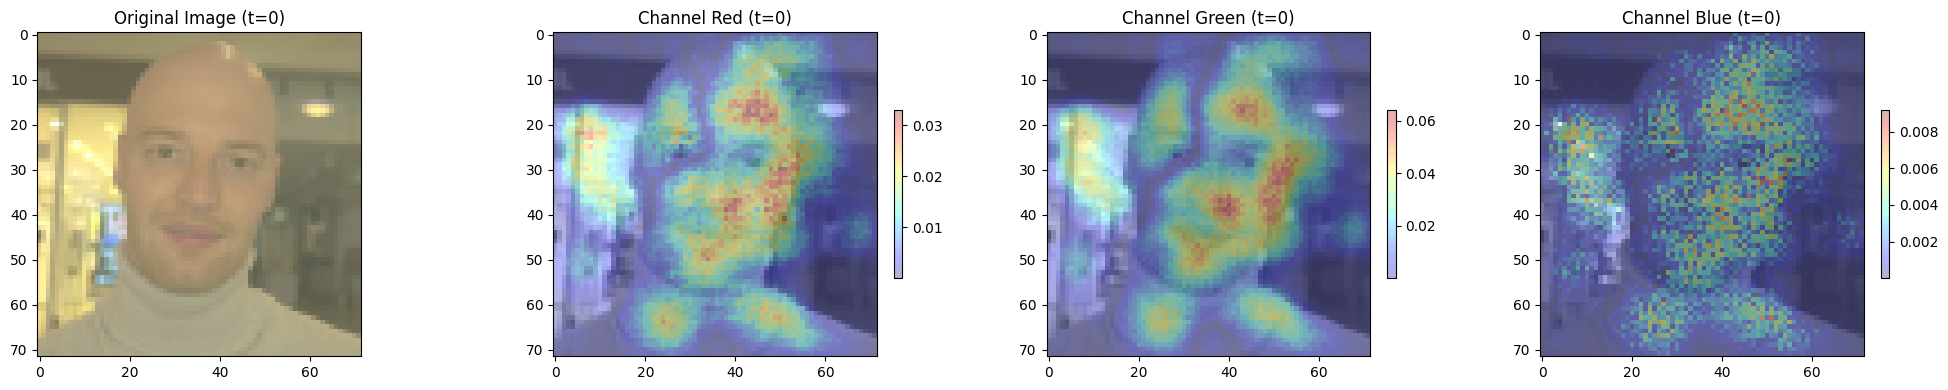

Visualizing uncertainty saliency map...


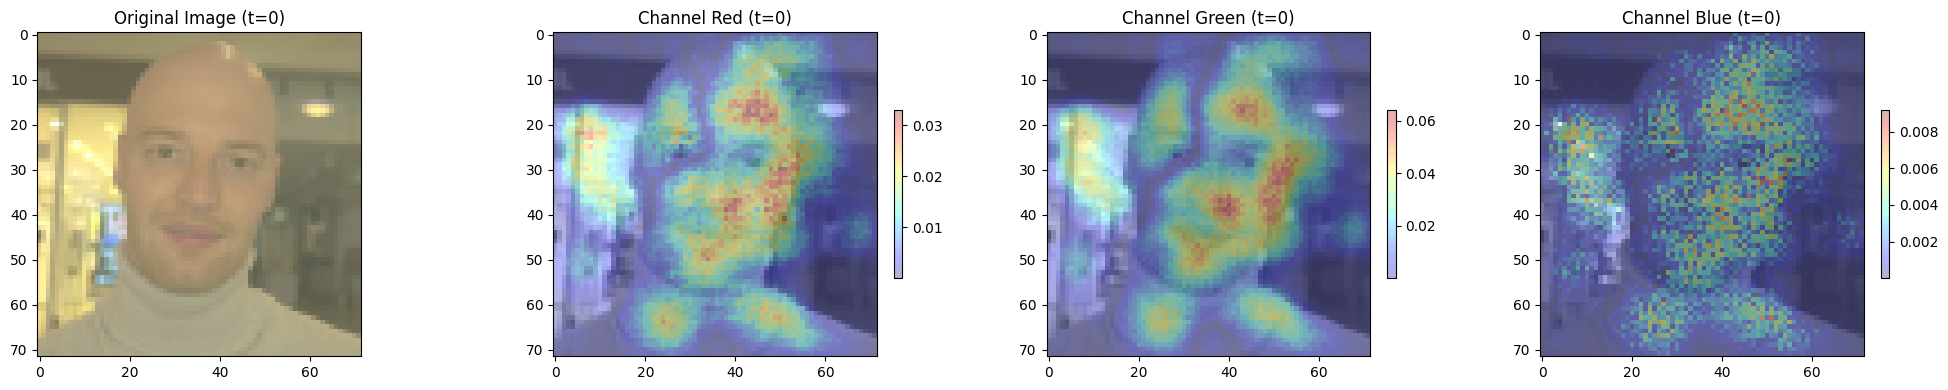

In [29]:
saliency_map, saliency_uncertainty = plot_noisy_input(noise_level=0.0)  # Adjust noise level as needed

In [30]:
def write_saliency_video(saliency, standardized_input, video_path):
    # Video settings
    T = standardized_input.shape[2]
    H, W = standardized_input.shape[-2:]
    print(f"Video dimensions: {H}x{W}, Total frames: {T}")
    fps = 30
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video_writer = cv2.VideoWriter(video_path, fourcc, fps, (W, H))

    # Loop through time steps
    for t in range(T):
        frame_float = standardized_input[0, :, t]  # [C, H, W]
        frame_float = (frame_float - frame_float.min()) / (frame_float.max() - frame_float.min() + 1e-8)  # Normalize to [0, 1]
        # Base grayscale image: average of the 3 input channels at time t
        base_gray = frame_float.mean(axis=0)  # [H, W]
        base_gray = np.clip((base_gray * 255), 0, 255).astype(np.uint8)
        base_rgb = (np.transpose(frame_float, (1, 2, 0)) * 255).astype(np.uint8)
        #base_rgb = cv2.cvtColor(base_gray, cv2.COLOR_GRAY2RGB)

        # Initialize a canvas for the combined saliency
        combined_saliency = np.zeros((H, W, 3), dtype=np.uint8)

        for c in range(3):
            # Get saliency map for this channel
            sal = saliency[c, t].cpu().numpy()  # [H, W]
            sal = (sal / (sal.max() + 1e-8) * 255).astype(np.uint8)  # Normalize to [0, 255]

            # Convert to 3-channel with color in channel `c`
            sal_rgb = np.zeros((H, W, 3), dtype=np.uint8)
            sal_rgb[:, :, c] = sal  # color tint: R, G, or B depending on c

            # Blend current saliency tint into the combined saliency image
            combined_saliency = cv2.addWeighted(combined_saliency, 1.0, sal_rgb, 0.5, 0)

        # Alpha blend combined saliency on top of the grayscale image
        blended = cv2.addWeighted(base_rgb, 0.5, combined_saliency, 2.0, 0)

        # Write to video
        blended_bgr = cv2.cvtColor(blended, cv2.COLOR_RGB2BGR)
        video_writer.write(blended_bgr)

    video_writer.release()
    print(f"Video saved to: {video_path}")

In [31]:
write_saliency_video(saliency_map, standardized_input, "saliency_overlay.mp4")

if is_uncertainty_model:
    write_saliency_video(saliency_uncertainty, standardized_input, "saliency_uncertainty_overlay.mp4")

Video dimensions: 72x72, Total frames: 160
Video saved to: saliency_overlay.mp4
Video dimensions: 72x72, Total frames: 160
Video saved to: saliency_uncertainty_overlay.mp4


Plotting with noise level: 0.05
Input tensor shape: torch.Size([1, 3, 160, 72, 72])
Output shape: torch.Size([1, 160]) Uncertainty output shape: torch.Size([1, 160])
Output shape after squeeze: torch.Size([]) torch.float32
Saliency shape: torch.Size([1, 3, 160, 72, 72])
Saliency shape: torch.Size([3, 160, 72, 72])
Output shape after squeeze: torch.Size([]) torch.float32
Saliency shape: torch.Size([1, 3, 160, 72, 72])
Saliency shape: torch.Size([3, 160, 72, 72])
Visializing saliency map...


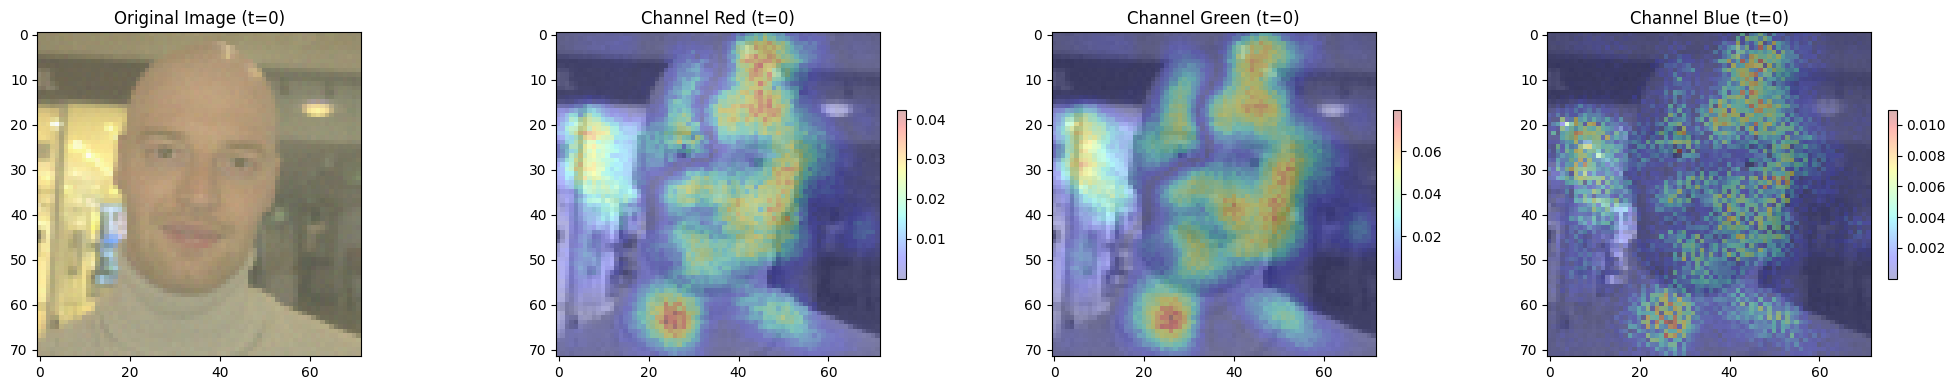

Visualizing uncertainty saliency map...


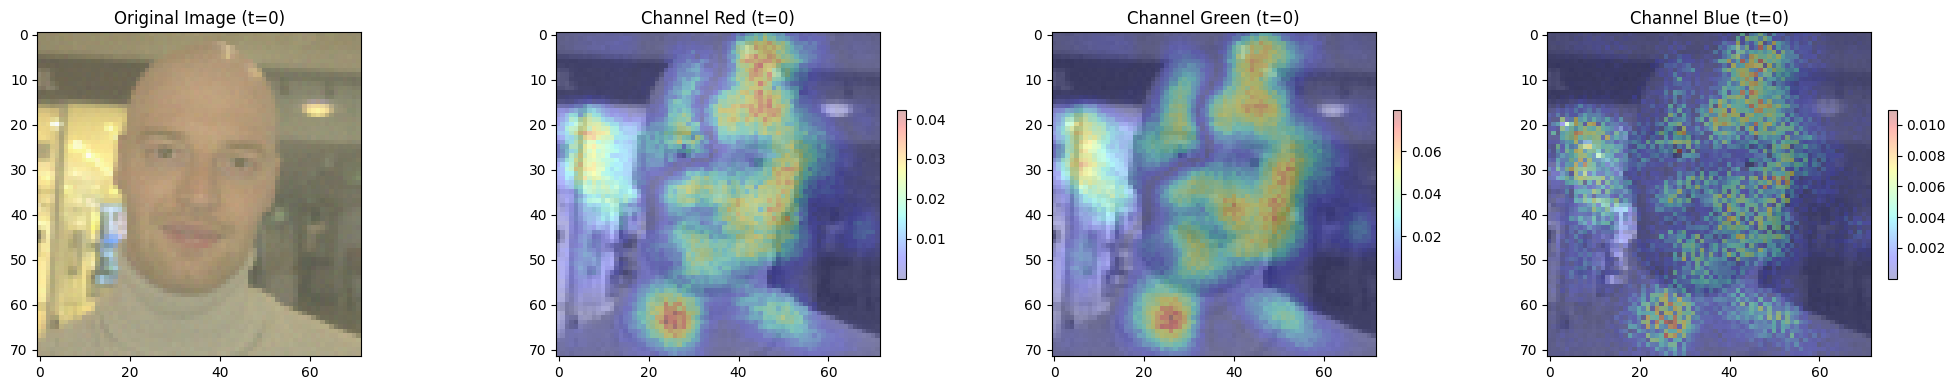

Plotting with noise level: 0.1
Input tensor shape: torch.Size([1, 3, 160, 72, 72])
Output shape: torch.Size([1, 160]) Uncertainty output shape: torch.Size([1, 160])
Output shape after squeeze: torch.Size([]) torch.float32
Saliency shape: torch.Size([1, 3, 160, 72, 72])
Saliency shape: torch.Size([3, 160, 72, 72])
Output shape after squeeze: torch.Size([]) torch.float32
Saliency shape: torch.Size([1, 3, 160, 72, 72])
Saliency shape: torch.Size([3, 160, 72, 72])
Visializing saliency map...


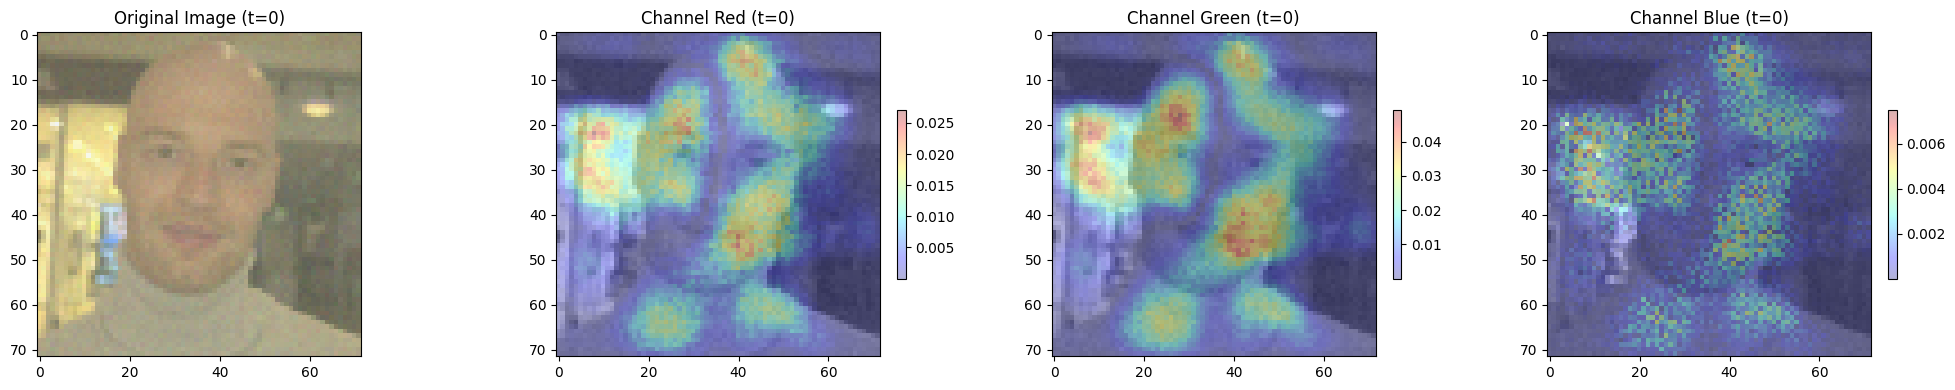

Visualizing uncertainty saliency map...


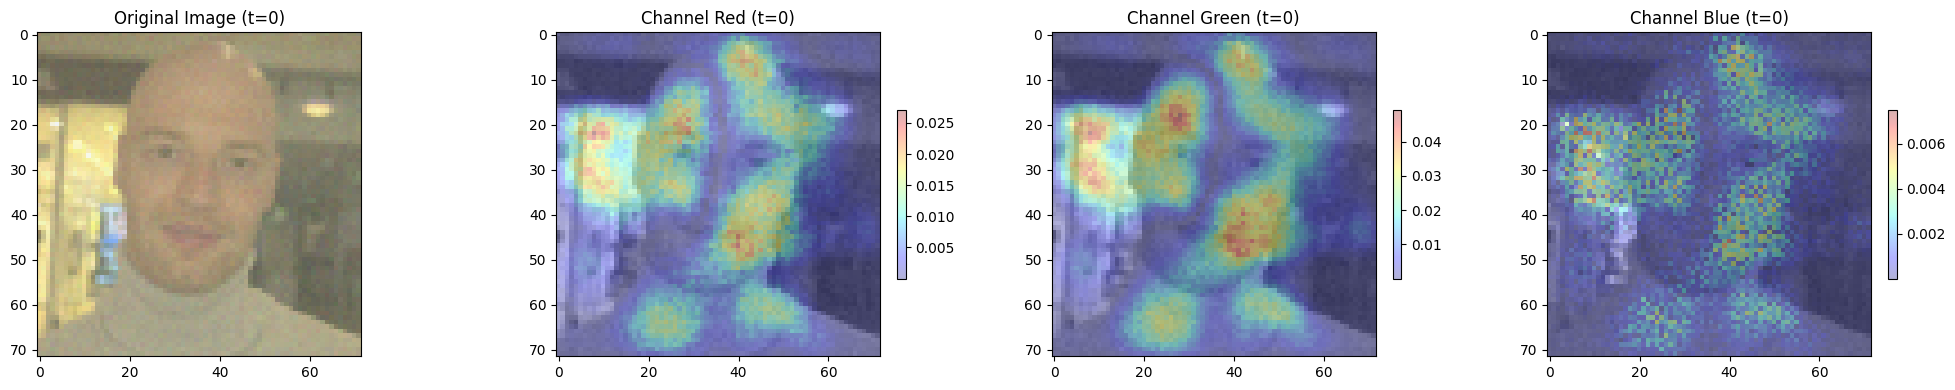

Plotting with noise level: 0.2
Input tensor shape: torch.Size([1, 3, 160, 72, 72])
Output shape: torch.Size([1, 160]) Uncertainty output shape: torch.Size([1, 160])
Output shape after squeeze: torch.Size([]) torch.float32
Saliency shape: torch.Size([1, 3, 160, 72, 72])
Saliency shape: torch.Size([3, 160, 72, 72])
Output shape after squeeze: torch.Size([]) torch.float32
Saliency shape: torch.Size([1, 3, 160, 72, 72])
Saliency shape: torch.Size([3, 160, 72, 72])
Visializing saliency map...


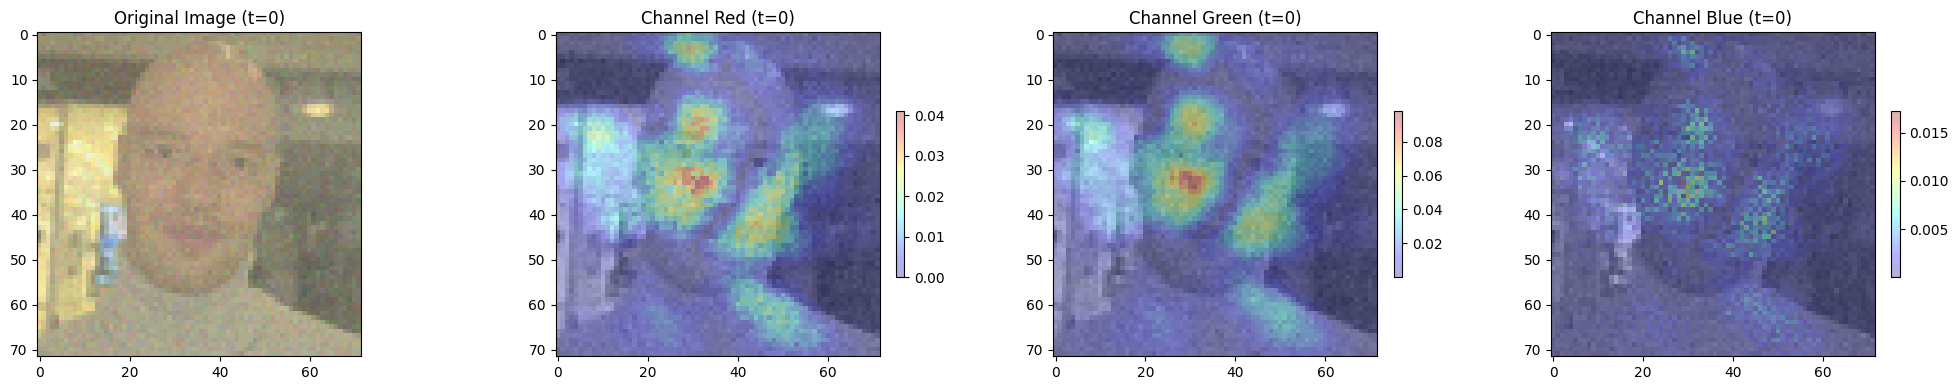

Visualizing uncertainty saliency map...


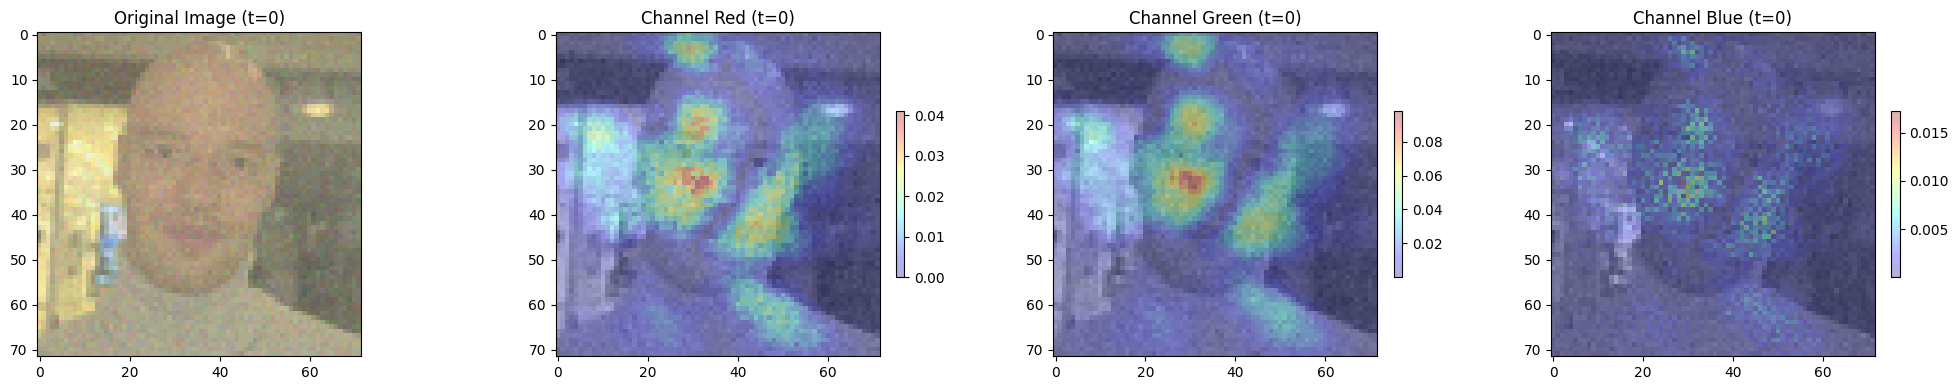

Plotting with noise level: 0.3
Input tensor shape: torch.Size([1, 3, 160, 72, 72])
Output shape: torch.Size([1, 160]) Uncertainty output shape: torch.Size([1, 160])
Output shape after squeeze: torch.Size([]) torch.float32
Saliency shape: torch.Size([1, 3, 160, 72, 72])
Saliency shape: torch.Size([3, 160, 72, 72])
Output shape after squeeze: torch.Size([]) torch.float32
Saliency shape: torch.Size([1, 3, 160, 72, 72])
Saliency shape: torch.Size([3, 160, 72, 72])
Visializing saliency map...


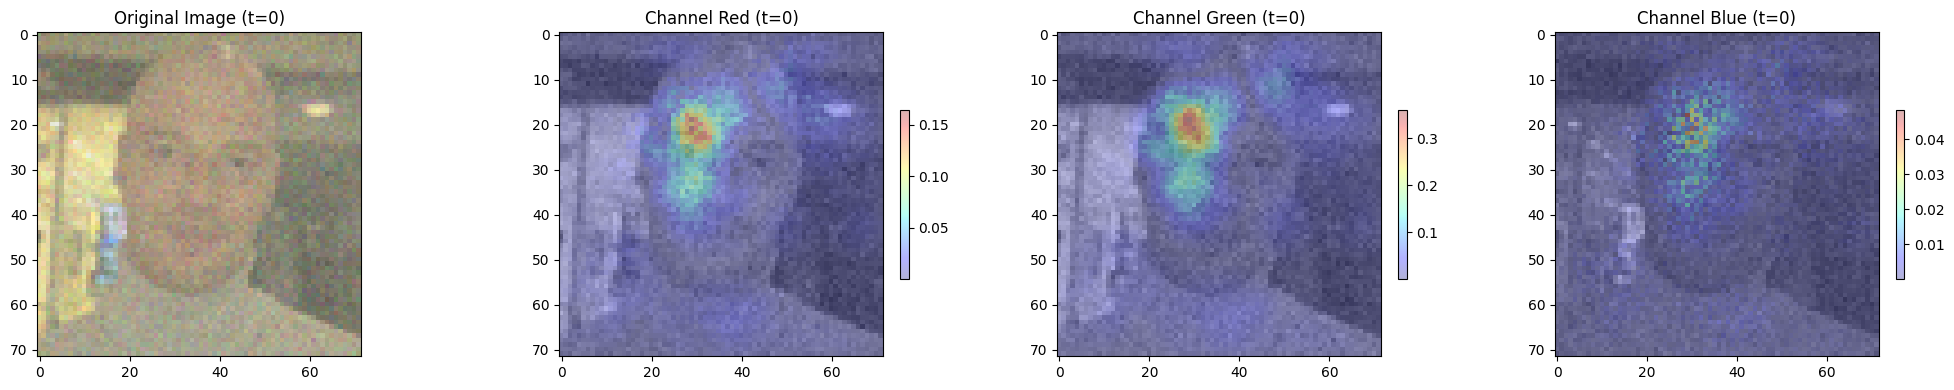

Visualizing uncertainty saliency map...


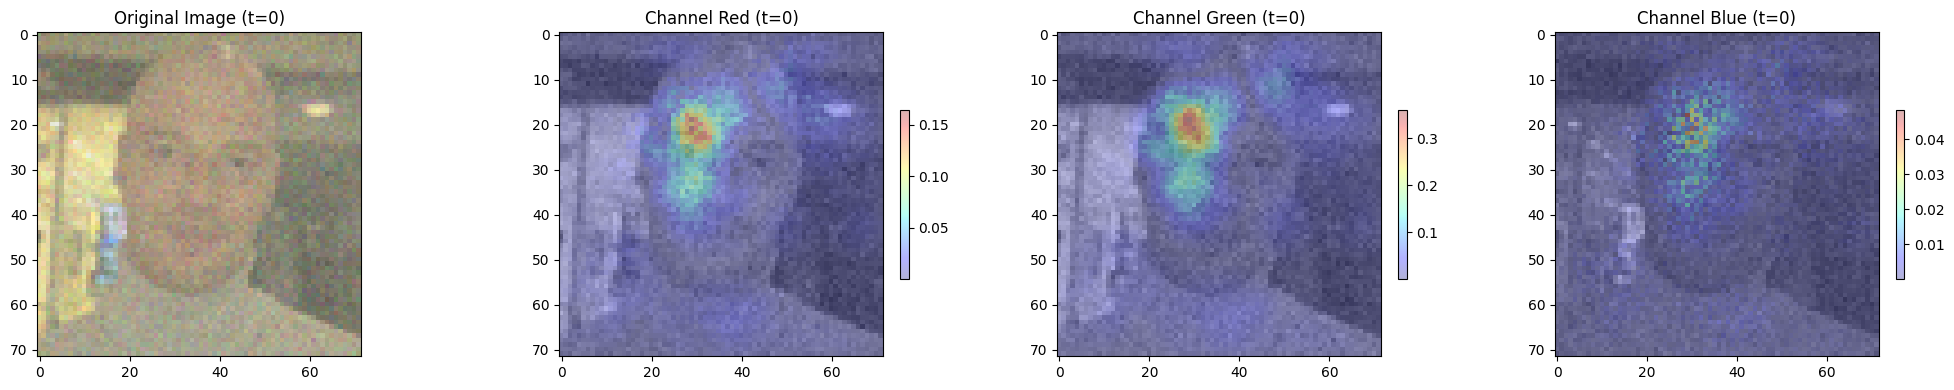

Plotting with noise level: 0.4
Input tensor shape: torch.Size([1, 3, 160, 72, 72])
Output shape: torch.Size([1, 160]) Uncertainty output shape: torch.Size([1, 160])
Output shape after squeeze: torch.Size([]) torch.float32
Saliency shape: torch.Size([1, 3, 160, 72, 72])
Saliency shape: torch.Size([3, 160, 72, 72])
Output shape after squeeze: torch.Size([]) torch.float32
Saliency shape: torch.Size([1, 3, 160, 72, 72])
Saliency shape: torch.Size([3, 160, 72, 72])
Visializing saliency map...


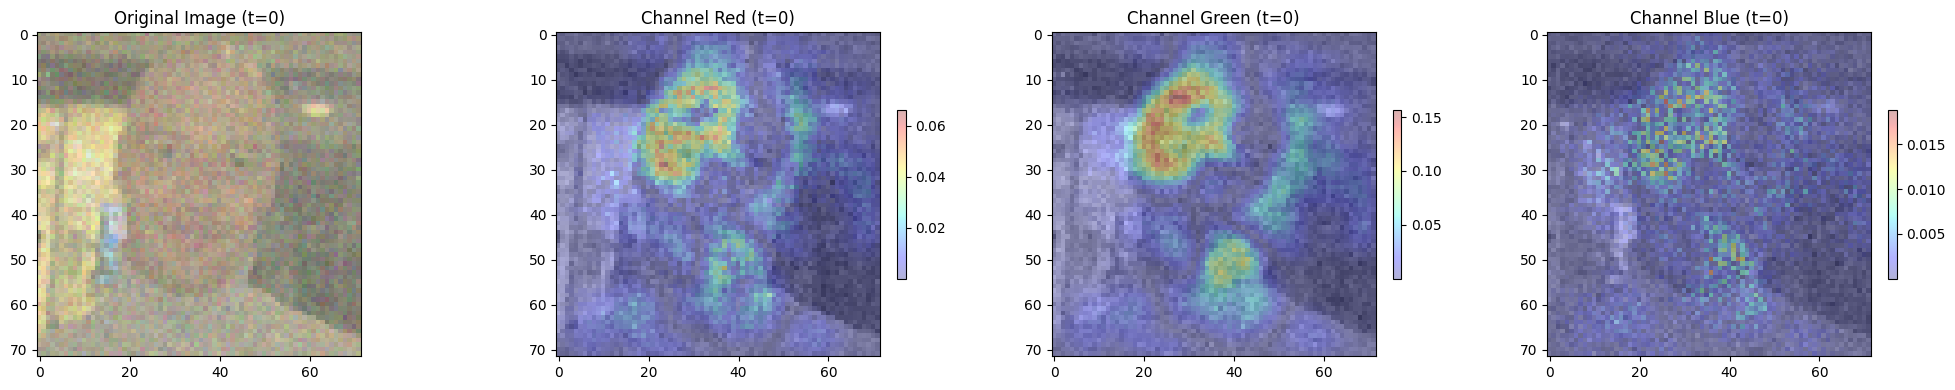

Visualizing uncertainty saliency map...


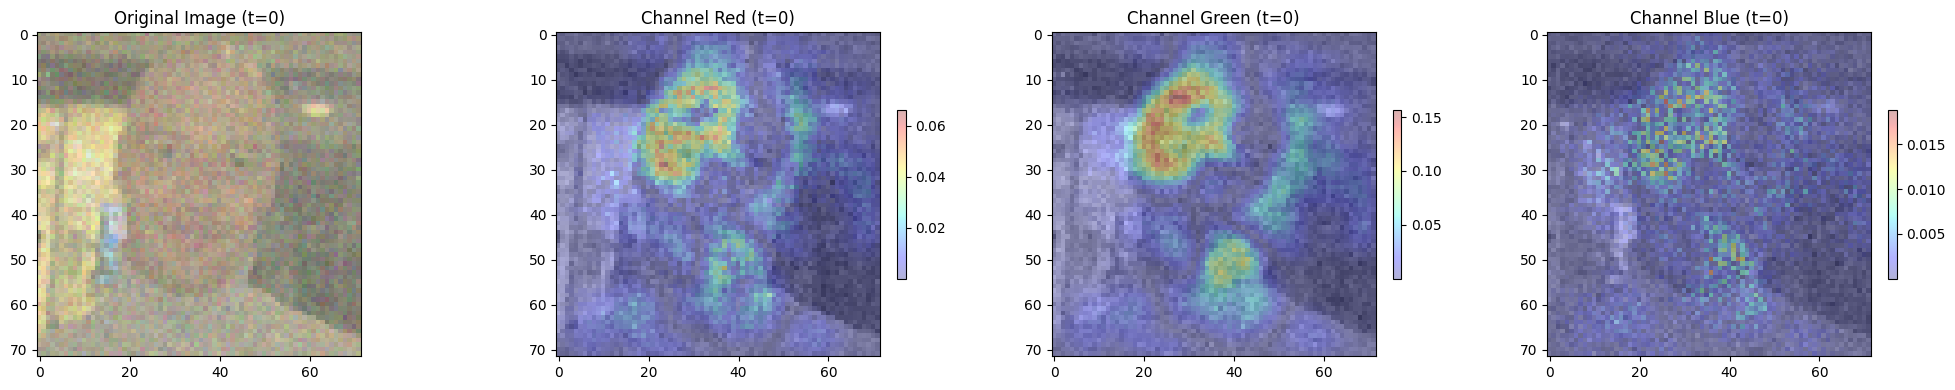

In [32]:
for noise_level in [0.05, 0.1, 0.2, 0.3, 0.4]:
    print(f"Plotting with noise level: {noise_level}")
    plot_noisy_input(noise_level=noise_level)  # Adjust noise level as needed